# 高度な予測
- 今回は番外編

今まではデータ分析において「なぜその値になるのか」「このデータの構造はどうなっているのか」「値の読み取り方」を中心に学んでいたため精度が高く、かつ素早く学習して予測するモデルを作ってはいなかった。

本項ではGBMとDNNを用いてより高い精度の予測を行うプログラムを作成する

## ライブラリのインポート
本項ではGBMにはLightGBMを使用し、DNNにはKerasを使用する。

In [1]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
import numpy as np

Using TensorFlow backend.
C:\Users\decar\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\decar\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\decar\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\decar\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## GBM

### 回帰

#### データの読み込み

In [2]:
df = pd.read_csv("boston.csv")
df.head()

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


#### データを「訓練データ」「検証用データ」「テストデータ」の3つに分ける

In [3]:
y = df["PRICE"]
x = df.drop("PRICE", axis=1)
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = tts(x_train, y_train, test_size=0.2, random_state=1)

#### GBMのモデルを定義して学習

In [4]:
params = {"objective" : "regression",
          "metric" : "rmse",
          "boosting_type" : "gbdt",
          "verbosity" : -1
         }
lgb_train = lgb.Dataset(x_train, y_train)
lgb.test = lgb.Dataset(x_val, y_val)
model_gbm_reg = lgb.train(params, lgb_train, valid_sets=lgb.test)
optimum_boost_rounds = model_gbm_reg.best_iteration

[1]	valid_0's rmse: 8.28473
[2]	valid_0's rmse: 7.76165
[3]	valid_0's rmse: 7.25305
[4]	valid_0's rmse: 6.85657
[5]	valid_0's rmse: 6.42871
[6]	valid_0's rmse: 6.14184
[7]	valid_0's rmse: 5.85755
[8]	valid_0's rmse: 5.63475
[9]	valid_0's rmse: 5.37579
[10]	valid_0's rmse: 5.21695
[11]	valid_0's rmse: 5.07532
[12]	valid_0's rmse: 4.96231
[13]	valid_0's rmse: 4.85721
[14]	valid_0's rmse: 4.76184
[15]	valid_0's rmse: 4.64796
[16]	valid_0's rmse: 4.52636
[17]	valid_0's rmse: 4.46001
[18]	valid_0's rmse: 4.3655
[19]	valid_0's rmse: 4.32931
[20]	valid_0's rmse: 4.25238
[21]	valid_0's rmse: 4.23111
[22]	valid_0's rmse: 4.17394
[23]	valid_0's rmse: 4.15529
[24]	valid_0's rmse: 4.09595
[25]	valid_0's rmse: 4.06909
[26]	valid_0's rmse: 4.02344
[27]	valid_0's rmse: 4.01069
[28]	valid_0's rmse: 3.97682
[29]	valid_0's rmse: 3.95666
[30]	valid_0's rmse: 3.91903
[31]	valid_0's rmse: 3.89738
[32]	valid_0's rmse: 3.88764
[33]	valid_0's rmse: 3.85098
[34]	valid_0's rmse: 3.81776
[35]	valid_0's rmse: 3.8

#### 予測精度を算出(決定係数)

In [5]:
y_pred = model_gbm_reg.predict(x_test)
print("R2:%.3f"%(r2_score(y_test, y_pred)))

R2:0.864


#### 回帰寄与率の算出

In [6]:
dfi_reg = pd.DataFrame(model_gbm_reg.feature_importance())
dfi_reg.index = x.columns
dfi_reg.columns = ["importances"]
dfi_reg.sort_values("importances", ascending=False)

,importances
LSTAT,198
DIS,189
RM,156
CRIM,115
B,115
AGE,110
NOX,84
TAX,72
PTRATIO,61
INDUS,41


#### 回帰寄与率のグラフ化

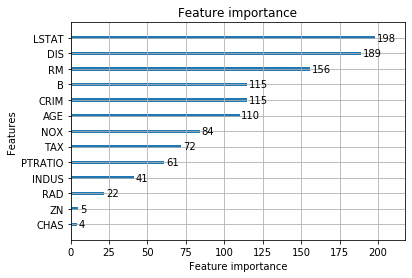

In [7]:
lgb.plot_importance(model_gbm_reg)
plt.show()

### 分類

#### データの読み込み

In [8]:
df = pd.read_csv("wine.csv")
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,0,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,0,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,0,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,0,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


#### データを「訓練データ」「検証用データ」「テストデータ」の3つに分ける

In [9]:
y = df["Wine"]
x = df.drop("Wine", axis=1)
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = tts(x_train, y_train, test_size=0.2, random_state=1)

#### GBMのモデルを定義して学習

In [10]:
params = {"objective" : "multiclass",
          "metric" : "multi_logloss", 
          "boosting_type" : "gbdt",
          "num_class" : 3,
          "verbosity" : -1
         }
lgb_train = lgb.Dataset(x_train, y_train)
lgb.test = lgb.Dataset(x_val, y_val)
model_gbm_cla = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb.test)
optimum_boost_rounds = model_gbm_cla.best_iteration

[1]	valid_0's multi_logloss: 0.948998
[2]	valid_0's multi_logloss: 0.853411
[3]	valid_0's multi_logloss: 0.765183
[4]	valid_0's multi_logloss: 0.693767
[5]	valid_0's multi_logloss: 0.634033
[6]	valid_0's multi_logloss: 0.571993
[7]	valid_0's multi_logloss: 0.519148
[8]	valid_0's multi_logloss: 0.483387
[9]	valid_0's multi_logloss: 0.44471
[10]	valid_0's multi_logloss: 0.41014
[11]	valid_0's multi_logloss: 0.384426
[12]	valid_0's multi_logloss: 0.359559
[13]	valid_0's multi_logloss: 0.341349
[14]	valid_0's multi_logloss: 0.320224
[15]	valid_0's multi_logloss: 0.297869
[16]	valid_0's multi_logloss: 0.280466
[17]	valid_0's multi_logloss: 0.266938
[18]	valid_0's multi_logloss: 0.256629
[19]	valid_0's multi_logloss: 0.24416
[20]	valid_0's multi_logloss: 0.231534
[21]	valid_0's multi_logloss: 0.221119
[22]	valid_0's multi_logloss: 0.212633
[23]	valid_0's multi_logloss: 0.204942
[24]	valid_0's multi_logloss: 0.196414
[25]	valid_0's multi_logloss: 0.190114
[26]	valid_0's multi_logloss: 0.17588

#### 予測精度の算出(正解率)
回帰とは異なり複数のクラスの中で最も高い数値のクラスのインデックスを予測結果にする

In [11]:
y_pred = model_gbm_cla.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("accuracy:%.3f"%(accuracy_score(y_test, y_pred)))

accuracy:1.000


#### 分類結果の詳細

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



#### 分類寄与率の算出

In [13]:
dfi_reg = pd.DataFrame(model_gbm_cla.feature_importance())
dfi_reg.index = x.columns
dfi_reg.columns = ["importances"]
dfi_reg.sort_values("importances", ascending=False)

,importances
Proline,251
Flavanoids,221
Color.int,185
Alcohol,117
OD,99
Mg,88
Nonflavanoid.phenols,77
Hue,52
Phenols,47
Ash,42


#### 分類寄与率のグラフ化

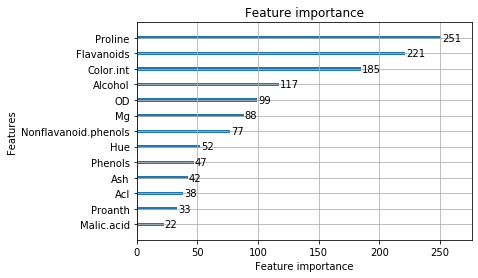

In [14]:
lgb.plot_importance(model_gbm_cla)
plt.show()

## DNN

### 回帰

#### データの読み込み

In [15]:
df = pd.read_csv("boston.csv")
df.head()

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


#### データの前処理(標準化)

In [16]:
x_tab = df.drop(["PRICE"], axis=1)
y_tab = df["PRICE"]
x_tab_std = x_tab.copy()
for col in x_tab.columns:
    x_tab_std[col] = (x_tab[col] - x_tab[col].mean()) / x_tab[col].std()
x_tab_std.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,8.326673e-17,3.466704e-16,-3.016965e-15,3.999875e-16,3.563575e-15,-1.149882e-14,-1.158274e-15,7.308603e-16,-1.068535e-15,6.534079e-16,-1.084420e-14,8.117354e-15,-6.494585e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.193669e-01,-4.872402e-01,-1.556302e+00,-2.723291e-01,-1.464433e+00,-3.876413e+00,-2.333128e+00,-1.265817e+00,-9.818712e-01,-1.312691e+00,-2.704703e+00,-3.903331e+00,-1.529613e+00
25%,-4.105633e-01,-4.872402e-01,-8.668328e-01,-2.723291e-01,-9.121262e-01,-5.680681e-01,-8.366200e-01,-8.048913e-01,-6.373311e-01,-7.668172e-01,-4.875567e-01,2.048688e-01,-7.986296e-01
50%,-3.902803e-01,-4.872402e-01,-2.108898e-01,-2.723291e-01,-1.440749e-01,-1.083583e-01,3.170678e-01,-2.790473e-01,-5.224844e-01,-4.642132e-01,2.745872e-01,3.808097e-01,-1.810744e-01
75%,7.389247e-03,4.872402e-02,1.014995e+00,-2.723291e-01,5.980871e-01,4.822906e-01,9.059016e-01,6.617161e-01,1.659603e+00,1.529413e+00,8.057784e-01,4.332223e-01,6.024226e-01
max,9.924110e+00,3.800473e+00,2.420170e+00,3.664771e+00,2.729645e+00,3.551530e+00,1.116390e+00,3.956602e+00,1.659603e+00,1.796416e+00,1.637208e+00,4.406159e-01,3.545262e+00


#### データを「訓練データ」「検証用データ」「テストデータ」に分割

In [17]:
x = x_tab_std.values
y = y_tab.values

In [18]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = tts(x_train, y_train, test_size=0.2, random_state=1)

#### ニューラルネットワークモデルを構築

In [19]:
model_dnn_reg = Sequential()
model_dnn_reg.add(Dense(50, input_dim=x_train.shape[1], activation="relu"))
model_dnn_reg.add(Dropout(0.2))
model_dnn_reg.add(Dense(32, activation="relu"))
model_dnn_reg.add(Dropout(0.2))
model_dnn_reg.add(Dense(1, activation="linear"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 学習に用いる精度指標を定義

In [20]:
model_dnn_reg.compile(loss="mean_squared_error", optimizer="adam")

#### 過学習防止

In [21]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)

#### 学習
学習を行なう時に過学習を防止するために検証用データを使いEarlystoppingで過学習をしている際に学習を止める。

In [22]:
hist = model_dnn_reg.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 323 samples, validate on 81 samples
Epoch 1/200
323/323 [==============================] - 1s 2ms/step - loss: 572.7188 - val_loss: 523.6897
Epoch 2/200
323/323 [==============================] - 0s 65us/step - loss: 537.9841 - val_loss: 493.7949
Epoch 3/200
323/323 [==============================] - 0s 68us/step - loss: 500.8310 - val_loss: 457.4697
Epoch 4/200
323/323 [==============================] - 0s 83us/step - loss: 459.3960 - val_loss: 410.7180
Epoch 5/200
323/323 [==============================] - 0s 62us/step - loss: 403.7230 - val_loss: 353.9063
Epoch 6/200
323/323 [==============================] - 0s 83us/step - loss: 337.4614 - val_loss: 286.9854
Epoch 7/200
323/323 [==============================] - 0s 65us/step - loss: 262.0360 - val_loss: 220.1505
Epoch 8/200
323/323 [==============================] - 0s 83us/step - loss: 195.8983 - val_loss: 161.7935
Epoch 9/200
323/323 [==============================] - 0s 77

#### 予測

In [23]:
y_pred = model_dnn_reg.predict(x_test)

#### 精度の算出(決定係数)

In [24]:
print("R2:%.3f"%(r2_score(y_test, y_pred)))

R2:0.843


#### 学習曲線を出力
ここで学習曲線を出力することで訓練データの精度と検証用データの精度の推移を確認できる

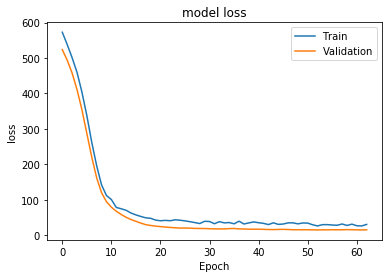

In [25]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()

### 分類

#### データの読み込み

In [26]:
df = pd.read_csv("wine.csv")
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,0,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,0,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,0,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,0,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


#### データの前処理(標準化)

In [27]:
x_tab = df.drop(["Wine"], axis=1)
y_tab = df["Wine"]
x_tab_std = x_tab.copy()
for col in x_tab.columns:
    x_tab_std[col] = (x_tab[col] - x_tab[col].mean()) / x_tab[col].std()
x_tab_std.describe()

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,7.757683e-15,-7.110417e-17,-4.079446e-15,9.882856e-16,-7.983626e-17,1.871162e-16,9.730044e-16,1.150141e-15,-2.413799e-15,-4.029236e-16,1.635396e-15,1.503167e-15,-3.898255e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.427388e+00,-1.428952e+00,-3.668813e+00,-2.663505e+00,-2.082381e+00,-2.101318e+00,-1.691200e+00,-1.862979e+00,-2.063214e+00,-1.629691e+00,-2.088840e+00,-1.889723e+00,-1.488987e+00
25%,-7.860275e-01,-6.568956e-01,-5.705131e-01,-6.871987e-01,-8.220960e-01,-8.829774e-01,-8.252115e-01,-7.380592e-01,-5.956034e-01,-7.928659e-01,-7.654033e-01,-9.495697e-01,-7.824306e-01
50%,6.082829e-02,-4.219218e-01,-2.375431e-02,1.514024e-03,-1.219377e-01,9.568993e-02,1.058511e-01,-1.755994e-01,-6.272092e-02,-1.587767e-01,3.303369e-02,2.370660e-01,-2.330629e-01
75%,8.337767e-01,6.679088e-01,6.961448e-01,6.003946e-01,5.082048e-01,8.067217e-01,8.466967e-01,6.078267e-01,6.274055e-01,4.925666e-01,7.111583e-01,7.863692e-01,7.561165e-01
max,2.253415e+00,3.100446e+00,3.147447e+00,3.145637e+00,4.359076e+00,2.532372e+00,3.054216e+00,2.395645e+00,3.475269e+00,3.425768e+00,3.292407e+00,1.955399e+00,2.963114e+00


#### データを「訓練データ」「検証用データ」「テストデータ」に分割

In [28]:
x = x_tab_std.values
y = y_tab.values

In [29]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = tts(x_train, y_train, test_size=0.2, random_state=1)

#### ニューラルネットワークモデルを定義

In [30]:
model_dnn_cla = Sequential()
model_dnn_cla.add(Dense(50, input_dim=x_train.shape[1], activation="relu"))
model_dnn_cla.add(Dropout(0.2))
model_dnn_cla.add(Dense(32, activation="relu"))
model_dnn_cla.add(Dropout(0.2))
model_dnn_cla.add(Dense(len(list(set(y_train))), activation="softmax"))

#### 学習に用いる精度指標を定義

In [31]:
model_dnn_cla.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#### 過学習防止

In [32]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)

#### 学習
ここでは検証用データの損失関数を用いて過学習を抑制している

In [33]:
hist = model_dnn_cla.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Train on 113 samples, validate on 29 samples
Epoch 1/200
113/113 [==============================] - 1s 6ms/step - loss: 1.2121 - acc: 0.3982 - val_loss: 1.0930 - val_acc: 0.5172
Epoch 2/200
113/113 [==============================] - 0s 97us/step - loss: 1.1397 - acc: 0.4336 - val_loss: 0.9933 - val_acc: 0.5862
Epoch 3/200
113/113 [==============================] - 0s 88us/step - loss: 0.9761 - acc: 0.5752 - val_loss: 0.9068 - val_acc: 0.5862
Epoch 4/200
113/113 [==============================] - 0s 89us/step - loss: 0.9360 - acc: 0.6106 - val_loss: 0.8312 - val_acc: 0.7931
Epoch 5/200
113/113 [==============================] - 0s 115us/step - loss: 0.8512 - acc: 0.6903 - val_loss: 0.7653 - val_acc: 0.8966
Epoch 6/200
113/113 [==============================] - 0s 144us/step - loss: 0.7586 - acc: 0.7876 - val_loss: 0.7067 - val_acc: 0.9310
Epoch 7/200
113/113 [==============================] - 0s 141us/step - loss: 0.6918 - acc: 0.8407 - val_loss: 0.6499 - val_acc: 0.9310
Epoch 8/200
113

Epoch 61/200
113/113 [==============================] - 0s 82us/step - loss: 0.0246 - acc: 1.0000 - val_loss: 0.0604 - val_acc: 1.0000
Epoch 62/200
113/113 [==============================] - 0s 88us/step - loss: 0.0291 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 1.0000
Epoch 63/200
113/113 [==============================] - 0s 88us/step - loss: 0.0550 - acc: 0.9912 - val_loss: 0.0583 - val_acc: 1.0000
Epoch 64/200
113/113 [==============================] - 0s 97us/step - loss: 0.0434 - acc: 0.9912 - val_loss: 0.0562 - val_acc: 1.0000
Epoch 65/200
113/113 [==============================] - 0s 97us/step - loss: 0.0263 - acc: 1.0000 - val_loss: 0.0557 - val_acc: 1.0000
Epoch 66/200
113/113 [==============================] - 0s 88us/step - loss: 0.0291 - acc: 1.0000 - val_loss: 0.0563 - val_acc: 1.0000
Epoch 67/200
113/113 [==============================] - 0s 97us/step - loss: 0.0381 - acc: 0.9912 - val_loss: 0.0573 - val_acc: 0.9655
Epoch 68/200
113/113 [==============================] -

113/113 [==============================] - 0s 97us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9655
Epoch 122/200
113/113 [==============================] - 0s 115us/step - loss: 0.0451 - acc: 0.9912 - val_loss: 0.0357 - val_acc: 0.9655
Epoch 123/200
113/113 [==============================] - 0s 132us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.0354 - val_acc: 1.0000
Epoch 124/200
113/113 [==============================] - 0s 97us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 1.0000
Epoch 125/200
113/113 [==============================] - 0s 88us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 1.0000
Epoch 126/200
113/113 [==============================] - 0s 124us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0340 - val_acc: 1.0000
Epoch 127/200
113/113 [==============================] - 0s 126us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 1.0000
Epoch 128/200
113/113 [==============================] - 0

#### 予測
テストデータによる予測を行う

In [34]:
y_pred = model_dnn_cla.predict(x_test)

#### 分類
予測結果について現状ではSoftmax関数の値が各クラスに入っているため、その中で最も高い値を取ったデータを予測ラベルにする

In [35]:
y_pred = np.argmax(y_pred, axis=1)

#### 予測結果の出力

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.92      0.96        13
           2       0.90      1.00      0.95         9

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.98      0.97      0.97        36



#### 学習曲線の出力
今回は分類であるため正解率を出力する

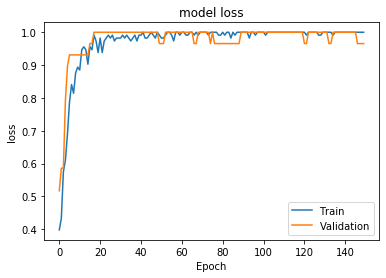

In [37]:
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()